In [1]:
import ipympl
%matplotlib inline
import matplotlib 
#matplotlib.use('inline')
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy.io
import gc
import datetime
import time
import random
import matplotlib
from _create_pdf import create_spins, create_spins_inhomo_g, create_spins_nocav
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _steady_state import a_steady
from _mbes import mbes, mbes_soc, obes, obes_soc
from _do_calculation import solve_mbes, solve_mbes_without_cavity, get_pulses_from_cavity_field, solve_mbes_wait, solve_mbes_only_decay, solve_obes
#matplotlib.pyplot.switch_backend('nbagg')
#%qtconsole

In [62]:
q = 1.0058273903894117
delta = 0*2*np.pi #detuning spins to drive frequency ws-wp
gperp = 2*np.pi*0.001 #HWHM
gpar = 2*np.pi*.0001#0.001 #HWHM
gammaq = 64.9152823091613
nbins = 1701#701#5000#20
g_number = 1 #how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)

In [63]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse

def pulse_rwa_gauss(t, args):
    wgrund = args[0]
    fcomps = args[1]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund
    
    width = 2*tend/(nfcomps+5)
    t0 = 3*width/2
    pulse = 0
    for i in range(len(fcomps)):
        pulse += fcomps[i]*np.exp(-4*(t-t0)**2*np.log(2)/width**2)
        t0 += 0.5*width
    pulse *= logistic.cdf(t, loc=0.01, scale=.002)*(1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    pulse *= 0.46971947398573455
    return pulse

def pulse_rwa_gauss_const(t, args):
    wgrund = args[0]
    fcomps = args[1]
    maxampl = args[2]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    #xint = np.linspace(0, tend, nfcomps)
    
    #spline = interpolate.BSpline(xint, fcomps, 2)
    spline = 0
    for i in range(len(fcomps)):
        spline += (fcomps[i])*np.sin((i+1)*wgrund*t)

    #spline = spline/nfcomps
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004)*(1-logistic.cdf(t, loc=tend-0.02, scale=0.004))
    
    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq


In [64]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)

x_start = 5
x_stop = 20 #µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

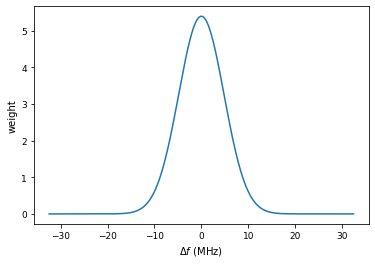

In [65]:
spins, pdf = create_spins_nocav(q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
fielddist = np.sqrt(pdf)
plt.figure()
plt.plot(spins[:len(pdf)], pdf*nbins)
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight');
#%qtconsole

# SOC pulses

In [66]:
pumptime = 2000e-3#5*np.pi/gcoll
decaytime = 20e-3
dt = 0.004
numsteps = int(pumptime/dt)
tlist = np.arange(0,pumptime+dt,dt)
tlistdecay = np.arange(0, decaytime+dt, dt)


# test time it takes to calculate


init = np.zeros(len(spins)*2)
init[1::2] = -1


### Calibrate power

In [67]:
pulsei = np.ones((len(tlist)))
pin = np.arange(-30, 0,0.5)
aref = 800

szlos = np.zeros((len(pin), len(tlist)+len(tlistdecay)))
szall = np.zeros((len(pin), len(tlist)+len(tlistdecay), nbins))
small = np.zeros(np.shape(szall))
smlos = np.zeros(np.shape(szlos))
for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    solpump, soldecay, infodict = solve_obes(obes, init, pdf, tlist, tlistdecay, dr, fielddist, gperp, spins, gpar)
    szlos[ctr, :] = np.hstack((np.real(np.sum(solpump[:, 1::2], axis=1)), np.real(np.sum(soldecay[:, 1::2], axis=1))))
    szall[ctr, :, :] = np.vstack((np.real(solpump[:,1::2]), np.real(soldecay[:,1::2])))
    small[ctr, :, :] = np.vstack((np.real(solpump[:,::2]), np.real(soldecay[:,::2])))
    smlos[ctr, :] = np.hstack((np.real(np.sum(solpump[:, ::2], axis=1)), np.real(np.sum(soldecay[:, ::2], axis=1))))

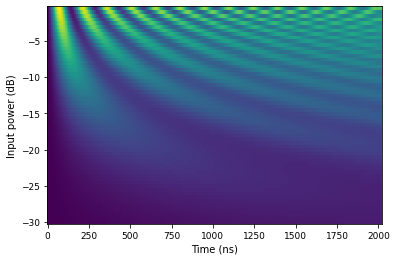

In [8]:
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))
#fig, (ax2) = plt.subplots(1,1, figsize=(15,5))
fig = plt.figure()
plt.pcolor(tplot, pin, szlos, shading="auto")
plt.xlabel('Time (ns)')
plt.ylabel('Input power (dB)');


In [86]:
fcomps = np.array([-1.177,  1.646, -0.549, -1.668, -0.627,  0.151,  1.68 , -0.024,
        0.858,  1.311, -0.15 , -0.355,  0.253,  1.165,  0.069,  0.47 ,
       -0.649, -0.814,  0.643, -0.657])
tscale = 3

wgrund = 2*np.pi/tscale
nfreqs = int(len(fcomps)/2)

tpsoc = np.arange(0, 0.504*tscale, dt)
scale = 1

dtf = 0.0005
tpf = np.arange(0, tpsoc[-1]+dtf, dtf)
init = np.ones(nbins*2)*(-1)
init[::2] = 0

ascalelist = np.linspace(0, 120, 50)
pulselist = []

solution = np.zeros((len(ascalelist), len(tpsoc), nbins*2),dtype=complex)

for i, ascale in enumerate(ascalelist):
    pulseif = pulse_rwa(tpf, (wgrund, fcomps[:nfreqs]))
    pulseqf = pulse_rwa(tpf, (wgrund, fcomps[nfreqs:]))

    pulsei = pulse_rwa(tpsoc, (wgrund, fcomps[:nfreqs]))
    pulseq = pulse_rwa(tpsoc, (wgrund, fcomps[nfreqs:]))
    pulsei *= ascale
    pulseq *= ascale
    pulseif *= ascale
    pulseqf *= ascale
    
    solutionpump, infodict = solve_obes(obes_soc, init, pdf, tpsoc, None, scale*pulsei, scale*pulseq, tpsoc, fielddist, gperp, spins, gpar)

    solution[i, :, :] = solutionpump

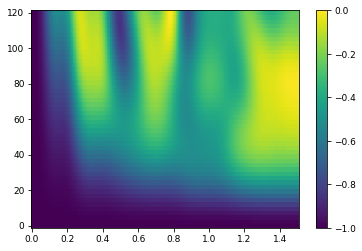

In [88]:
middleidx = int(nbins/2)
idxm = 50
c = plt.pcolor(tpsoc, ascalelist, np.real(np.sum(solution[:, :, 1::2], axis=2)), shading='auto')
fig.colorbar(c, ax=plt.gca())

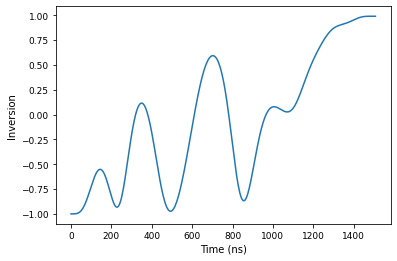

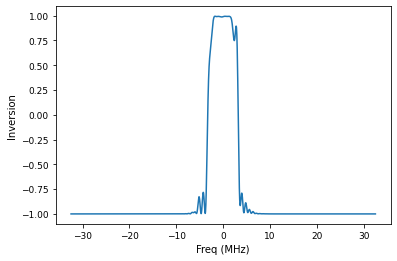

In [89]:
dummyarr = np.sum(solution[:, -1, 1::2], axis=1)
maxidx = int(np.where(dummyarr==max(dummyarr))[0])

plt.figure()
plt.plot(tpsoc*1000, np.real(solution[maxidx, :, nbins])/pdf[middleidx])
plt.xlabel("Time (ns)")
plt.ylabel("Inversion");

plt.figure()
plt.plot(spins, np.real(solution[maxidx, -1, 1::2])/pdf)
plt.xlabel("Freq (MHz)")
plt.ylabel("Inversion");